In [1]:
import json
import pandas as pd
import glob
import os
from pathlib import Path
import math
import numpy as np

In [2]:
FOLDER = "./results_trivia_qa"

In [3]:
def extract_model_name(filename):
    """Extract model name from results_*.json filename."""
    # Remove 'results_' prefix and '.json' suffix
    basename = os.path.basename(filename)
    model_name = basename.replace('results_', '').replace('.json', '')
    return model_name

In [4]:
def load_results_files(directory_path):
    """Load all results_*.json files from the specified directory."""
    # Find all results_*.json files
    pattern = os.path.join(directory_path, "results_*.json")
    json_files = glob.glob(pattern)

    paraphrase_data = []
    qa_data = []

    for json_file in json_files:
        model_name = extract_model_name(json_file)

        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            # Extract paraphrase data
            if 'paraphrase' in data:
                para_row = data['paraphrase'].copy()
                para_row['model_name'] = model_name
                # Move model_name to the front
                para_row = {'model_name': para_row.pop('model_name'), **para_row}
                paraphrase_data.append(para_row)

            # Extract QA data
            if 'qa' in data:
                qa_row = data['qa'].copy()
                qa_row['model_name'] = model_name
                # Move model_name to the front
                qa_row = {'model_name': qa_row.pop('model_name'), **qa_row}
                qa_data.append(qa_row)

        except (json.JSONDecodeError, FileNotFoundError) as e:
            print(f"Error processing {json_file}: {e}")
            continue

    return paraphrase_data, qa_data


In [5]:
def process():
    # Get the directory containing this script
    script_dir = FOLDER

    print(f"Processing JSON files in: {script_dir}")

    # Load data from all results_*.json files
    paraphrase_data, qa_data = load_results_files(script_dir)

    if not paraphrase_data and not qa_data:
        print("No results_*.json files found or no data extracted.")
        return

    # Create DataFrames
    if paraphrase_data:
        paraphrase_df = pd.DataFrame(paraphrase_data)
        # Sort by model_name for consistent ordering
        paraphrase_df = paraphrase_df.sort_values('model_name').reset_index(drop=True)

        # Save to CSV
        paraphrase_csv = os.path.join(script_dir, "paraphrase_results.csv")
        paraphrase_df.to_csv(paraphrase_csv, index=False)
        print(f"Paraphrase data saved to: {paraphrase_csv}")
        print(f"Paraphrase DataFrame shape: {paraphrase_df.shape}")
        print(f"Models in paraphrase data: {list(paraphrase_df['model_name'])}")
    else:
        print("No paraphrase data found.")

    if qa_data:
        qa_df = pd.DataFrame(qa_data)
        # Sort by model_name for consistent ordering
        qa_df = qa_df.sort_values('model_name').reset_index(drop=True)

        # Save to CSV
        qa_csv = os.path.join(script_dir, "qa_results.csv")
        qa_df.to_csv(qa_csv, index=False)
        print(f"QA data saved to: {qa_csv}")
        print(f"QA DataFrame shape: {qa_df.shape}")
        print(f"Models in QA data: {list(qa_df['model_name'])}")
    else:
        print("No QA data found.")

    # Print summary
    print(f"\nSummary:")
    print(f"- Processed {len(set([item['model_name'] for item in paraphrase_data + qa_data]))} unique models")
    print(f"- Paraphrase records: {len(paraphrase_data)}")
    print(f"- QA records: {len(qa_data)}")

    return paraphrase_df, qa_df


In [6]:
paraphrase_df, qa_df = process()

Processing JSON files in: ./results_trivia_qa
Paraphrase data saved to: ./results_trivia_qa/paraphrase_results.csv
Paraphrase DataFrame shape: (7, 31)
Models in paraphrase data: ['Qwen3-Embedding-4B', 'Qwen3-Embedding-8B', 'SFR-Embedding-Mistral', 'granite-embedding-30m-english', 'granite-embedding-small-english-r2', 'text-embedding-3-large', 'text-embedding-3-small']
QA data saved to: ./results_trivia_qa/qa_results.csv
QA DataFrame shape: (7, 31)
Models in QA data: ['Qwen3-Embedding-4B', 'Qwen3-Embedding-8B', 'SFR-Embedding-Mistral', 'granite-embedding-30m-english', 'granite-embedding-small-english-r2', 'text-embedding-3-large', 'text-embedding-3-small']

Summary:
- Processed 7 unique models
- Paraphrase records: 7
- QA records: 7


In [7]:
paraphrase_df.head()

,model_name,model,para_dataset,n_pairs,dim,H,alpha,mu,js_mode,AUC_cos,...,JS_pred_low,JS_pred_high,CCS,eta_JL,Nmax_eta_0.2,Nmax_eta_0.15,Nmax_eta_0.1,cos_mean,delta_mean,delta_mean_operator_space
0,Qwen3-Embedding-4B,../../llm-models/Qwen3-Embedding-4B,stsb,1000,2560,64,11.615265,0.000391,hyp,0.917032,...,0.070266,1.245106,0.658361,0.175922,3.622174e+04,133.943076,2.453253,0.810294,0.562662,54.790591
1,Qwen3-Embedding-8B,../../llm-models/Qwen3-Embedding-8B,stsb,1000,4096,64,12.373783,0.000391,hyp,0.926784,...,0.071156,1.391752,0.690494,0.139078,7.840631e+07,10070.996187,16.733537,0.815655,0.552712,57.826674
2,SFR-Embedding-Mistral,../../llm-models/SFR-Embedding-Mistral,stsb,1000,4096,64,15.517885,0.000391,hyp,0.915132,...,0.097474,1.688943,0.685701,0.139078,7.840631e+07,10070.996187,16.733537,0.850059,0.494991,62.694671
3,granite-embedding-30m-english,../../llm-models/granite-embedding-30m-english,stsb,1000,384,64,17.723754,0.000391,hyp,0.853112,...,0.716284,6.598551,0.664974,0.454228,6.820958e-01,0.294468,0.161607,0.879879,0.452560,17.731963
4,granite-embedding-small-english-r2,../../llm-models/granite-embedding-small-engli...,stsb,1000,384,64,30.585697,0.000391,hyp,0.852740,...,0.826179,7.605789,0.655464,0.454228,6.820958e-01,0.294468,0.161607,0.922673,0.367020,18.516661


In [8]:
paraphrase_df.columns

Index(['model_name', 'model', 'para_dataset', 'n_pairs', 'dim', 'H', 'alpha',
       'mu', 'js_mode', 'AUC_cos', 'AUC_negJS', 'JS_mean', 'C_low', 'C_high',
       'C_ratio', 'BTI', 'DataFit', 'delta_op', 'delta_op_resid',
       'delta_op_note', 'jl_constant', 'JS_pred_low', 'JS_pred_high', 'CCS',
       'eta_JL', 'Nmax_eta_0.2', 'Nmax_eta_0.15', 'Nmax_eta_0.1', 'cos_mean',
       'delta_mean', 'delta_mean_operator_space'],
      dtype='object')

In [9]:
# convert Nmax_eta_ fields to int
for col in paraphrase_df.columns:
    if col.startswith("Nmax_eta_"):
        paraphrase_df[col] = paraphrase_df[col].astype(int)

for col in qa_df.columns:
    if col.startswith("Nmax_eta_"):
        qa_df[col] = qa_df[col].astype(int)

In [10]:
# print model_name and fit
p = paraphrase_df[["model_name", "dim", "DataFit", "BTI", "delta_op", "eta_JL", "CCS", "cos_mean", "Nmax_eta_0.2", "Nmax_eta_0.15"]].sort_values("DataFit", ascending=False)
p.style.format({"DataFit": "{:.3f}", "BTI": "{:.3f}", "delta_op": "{:.3f}", "eta_JL": "{:.3f}", "CCS": "{:.3f}", "cos_mean": "{:.3f}"})

,model_name,dim,DataFit,BTI,delta_op,eta_JL,CCS,cos_mean,Nmax_eta_0.2,Nmax_eta_0.15
2,SFR-Embedding-Mistral,4096,0.780,0.454,1.961,0.139,0.686,0.850,78406305,10070
1,Qwen3-Embedding-8B,4096,0.764,0.430,1.960,0.139,0.690,0.816,78406305,10070
0,Qwen3-Embedding-4B,2560,0.679,0.450,1.961,0.176,0.658,0.810,36221,133
5,text-embedding-3-large,3072,0.466,0.198,1.960,0.161,0.754,0.720,468557,565
6,text-embedding-3-small,1536,0.445,0.258,1.961,0.227,0.768,0.729,216,7
4,granite-embedding-small-english-r2,384,0.351,0.595,2.971,0.454,0.655,0.923,0,0
3,granite-embedding-30m-english,384,0.320,0.594,3.506,0.454,0.665,0.880,0,0


In [11]:
# print model_name and fit
q = qa_df[["model_name", "dim", "DataFit", "BTI", "delta_op", "eta_JL", "CCS", "cos_mean", "Nmax_eta_0.2", "Nmax_eta_0.15"]].sort_values("DataFit", ascending=False)
q.style.format({"DataFit": "{:.3f}", "BTI": "{:.3f}", "delta_op": "{:.3f}", "eta_JL": "{:.3f}", "CCS": "{:.3f}", "cos_mean": "{:.3f}"})

,model_name,dim,DataFit,BTI,delta_op,eta_JL,CCS,cos_mean,Nmax_eta_0.2,Nmax_eta_0.15
5,text-embedding-3-large,3072,0.710,0.750,1.406,0.161,0.553,0.423,468557,565
6,text-embedding-3-small,1536,0.599,0.749,1.433,0.227,0.517,0.348,216,7
2,SFR-Embedding-Mistral,4096,0.521,0.919,1.400,0.139,0.404,0.670,78406305,10070
1,Qwen3-Embedding-8B,4096,0.370,0.820,1.404,0.139,0.186,0.493,78406305,10070
0,Qwen3-Embedding-4B,2560,0.337,0.762,1.411,0.176,0.259,0.557,36221,133
3,granite-embedding-30m-english,384,0.077,0.710,4.552,0.454,0.318,0.550,0,0
4,granite-embedding-small-english-r2,384,0.040,0.681,4.236,0.454,0.277,0.743,0,0


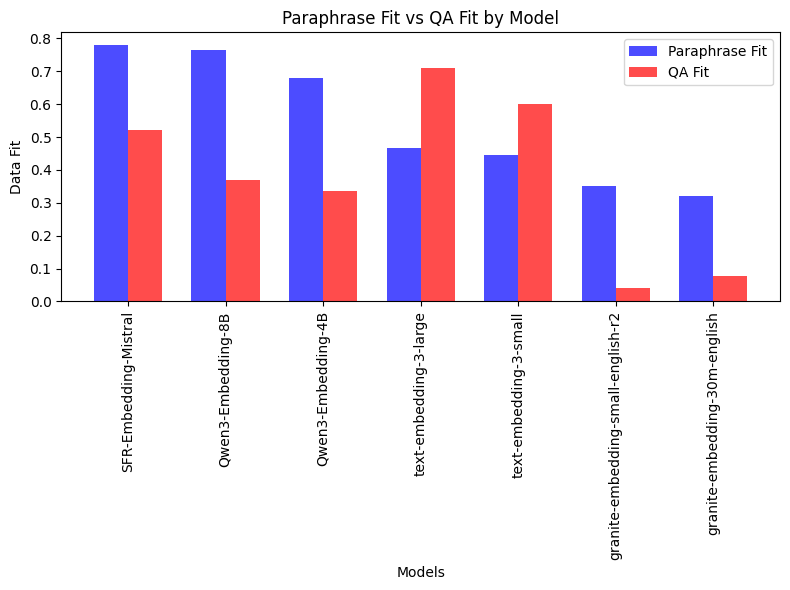

In [12]:
# plot paraphrase fit vs qa fit as BAR chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
merged_df = pd.merge(paraphrase_df, qa_df, on="model_name", suffixes=("_para", "_qa"))
merged_df = merged_df.sort_values("DataFit_para", ascending=False)
bar_width = 0.35
indices = np.arange(len(merged_df))
plt.bar(indices, merged_df["DataFit_para"], width=bar_width, label="Paraphrase Fit", color='b', alpha=0.7)
plt.bar(indices + bar_width, merged_df["DataFit_qa"], width=bar_width, label="QA Fit", color='r', alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Data Fit")
plt.title("Paraphrase Fit vs QA Fit by Model")
plt.xticks(indices + bar_width / 2, merged_df["model_name"], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()